In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)

print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')

initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

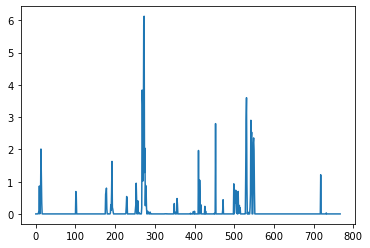

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
   
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    
    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    
    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

peturbed flow 0.018654659419180403
peturbed flow 0.018654659419180403
under estimaiton ratio [3639.6382378]
under estimaiton [44.97663127]
CFE [0.01868782]
enkf [68.01691072]
peturbed flow 0.018654659419180403
peturbed flow 0.021563273972922178
peturbed flow 0.021563273972922178
under estimaiton ratio [3280.47236127]
under estimaiton [46.85894045]
CFE [0.02744206]
enkf [90.02292875]
peturbed flow 0.021563273972922178
peturbed flow 0.02427580099266572
peturbed flow 0.02427580099266572
under estimaiton ratio [3482.52378942]
under estimaiton [56.00270968]
CFE [0.02658749]
enkf [92.59156526]
peturbed flow 0.02427580099266572
peturbed flow 0.02679769104502549
peturbed flow 0.02679769104502549
under estimaiton ratio [1342.41869739]
under estimaiton [23.83014849]
CFE [0.02938571]
enkf [39.44792695]
peturbed flow 0.02679769104502549
peturbed flow 0.02913555651218288
peturbed flow 0.02913555651218288
under estimaiton ratio [2779.16348244]
under estimaiton [53.63876783]
CFE [0.02981532]
enkf [82

under estimaiton ratio [123.43554672]
under estimaiton [10.82662979]
CFE [0.10223809]
enkf [12.6198143]
peturbed flow 0.13240721813203207
peturbed flow 0.1313939184589667
peturbed flow 0.1313939184589667
under estimaiton ratio [268.13955885]
under estimaiton [23.33874696]
CFE [0.13721142]
enkf [36.7918098]
peturbed flow 0.1313939184589667
peturbed flow 0.13036543150697308
peturbed flow 0.13036543150697308
under estimaiton ratio [329.29187534]
under estimaiton [28.43706969]
CFE [0.12367386]
enkf [40.72479772]
peturbed flow 0.13036543150697308
peturbed flow 0.1293224490830007
peturbed flow 0.1293224490830007
under estimaiton ratio [221.48595154]
under estimaiton [18.97411314]
CFE [0.14119476]
enkf [31.2726556]
peturbed flow 0.1293224490830007
peturbed flow 0.12826565307502358
peturbed flow 0.12826565307502358
under estimaiton ratio [68.61031833]
under estimaiton [5.82963268]
CFE [0.13653037]
enkf [9.36739225]
peturbed flow 0.12826565307502358
peturbed flow 0.1271957166204256
peturbed flo

under estimaiton ratio [184.68326699]
under estimaiton [17.04678281]
CFE [0.15056032]
enkf [27.80597199]
peturbed flow 0.13933925978364026
peturbed flow 0.13827485662441535
peturbed flow 0.13827485662441535
under estimaiton ratio [58.87279499]
under estimaiton [5.39261297]
CFE [0.1662548]
enkf [9.78788453]
peturbed flow 0.13827485662441535
peturbed flow 0.13719020341485907
peturbed flow 0.13719020341485907
under estimaiton ratio [249.87584131]
under estimaiton [22.70851578]
CFE [0.11776407]
enkf [29.42639666]
peturbed flow 0.13719020341485907
peturbed flow 0.13608717448236443
peturbed flow 0.13608717448236443
under estimaiton ratio [188.51363484]
under estimaiton [16.99422425]
CFE [0.10837186]
enkf [20.42957251]
peturbed flow 0.13608717448236443
peturbed flow 0.13496746709427634
peturbed flow 0.13496746709427634
under estimaiton ratio [262.75889584]
under estimaiton [23.49242809]
CFE [0.1093834]
enkf [28.74146186]
peturbed flow 0.13496746709427634
peturbed flow 0.13383262185243688
petu

under estimaiton ratio [144.94126721]
under estimaiton [22.54003389]
CFE [0.19669607]
enkf [28.50937769]
peturbed flow 0.2347583943329508
peturbed flow 0.2360492339048035
peturbed flow 0.2360492339048035
under estimaiton ratio [122.44244736]
under estimaiton [19.14590842]
CFE [0.23654285]
enkf [28.96288587]
peturbed flow 0.2360492339048035
peturbed flow 0.23698887669707072
peturbed flow 0.23698887669707072
under estimaiton ratio [44.11960523]
under estimaiton [6.92629462]
CFE [0.24512534]
enkf [10.81483331]
peturbed flow 0.23698887669707072
peturbed flow 0.23761189024932053
peturbed flow 0.23761189024932053
under estimaiton ratio [157.02244509]
under estimaiton [24.71560725]
CFE [0.18323149]
enkf [28.77145597]
peturbed flow 0.23761189024932053
peturbed flow 0.23795035427138742
peturbed flow 0.23795035427138742
under estimaiton ratio [67.53520906]
under estimaiton [10.64530195]
CFE [0.20127293]
enkf [13.59300925]
peturbed flow 0.23795035427138742
peturbed flow 0.2380337894529513
peturbe

peturbed flow 0.2655542439768875
peturbed flow 0.263042421198801
peturbed flow 0.263042421198801
under estimaiton ratio [123.5920075]
under estimaiton [21.53562897]
CFE [0.31663875]
enkf [39.13401831]
peturbed flow 0.263042421198801
peturbed flow 0.2605193866680155
peturbed flow 0.2605193866680155
peturbed flow 0.2605193866680155
peturbed flow 0.25798646093321004
peturbed flow 0.25798646093321004
under estimaiton ratio [222.80725138]
under estimaiton [38.07742894]
CFE [0.23839598]
enkf [53.11635405]
peturbed flow 0.25798646093321004
peturbed flow 0.25544486192583965
peturbed flow 0.25544486192583965
peturbed flow 0.25544486192583965
peturbed flow 0.2528957209643249
peturbed flow 0.2528957209643249
under estimaiton ratio [185.43517845]
under estimaiton [31.06525966]
CFE [0.24587241]
enkf [45.59339405]
peturbed flow 0.2528957209643249
peturbed flow 0.25034009629905263
peturbed flow 0.25034009629905263
peturbed flow 0.25034009629905263
peturbed flow 0.2477789845392864
peturbed flow 0.2477

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:63: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


[0.2425628]
enkf [41.06974807]
peturbed flow 0.19553659029752388
peturbed flow 0.19312967644238205
peturbed flow 0.19312967644238205
peturbed flow 0.19312967644238205
peturbed flow 0.19072677612695416
peturbed flow 0.19072677612695416
under estimaiton ratio [100.76637201]
under estimaiton [12.73118036]
CFE [0.25469283]
enkf [25.66447238]
peturbed flow 0.19072677612695416
peturbed flow 0.2668832594384667
peturbed flow 0.2668832594384667
peturbed flow 7.9915703448807305
peturbed flow 1.4719163968915858
peturbed flow 1.4719163968915858
under estimaiton ratio [20.3092895]
under estimaiton [19.80246498]
CFE [1.52311301]
enkf [30.93334311]
peturbed flow 32.05063250708977
peturbed flow 1.3813430175163126
peturbed flow 1.3813430175163126
peturbed flow 28.289798709059646
peturbed flow 0.990688500788774
peturbed flow 0.990688500788774
under estimaiton ratio [31.89919055]
under estimaiton [20.93428659]
CFE [1.07117939]
enkf [34.16975553]
peturbed flow 18.251840380116597
peturbed flow 0.5761612907

under estimaiton ratio [2.18956262]
under estimaiton [18.77761948]
CFE [13.43908308]
enkf [29.42571398]
peturbed flow 32.54948657520716
peturbed flow 8.502042800337005
peturbed flow 8.502042800337005
under estimaiton ratio [1.88156842]
under estimaiton [10.59704266]
CFE [8.61395062]
enkf [16.20773747]
peturbed flow 20.041072405897918
peturbed flow 6.8671539816731135
peturbed flow 6.8671539816731135
under estimaiton ratio [2.02446909]
under estimaiton [9.20935716]
CFE [5.7568181]
enkf [11.6545003]
peturbed flow 15.243845593978707
peturbed flow 4.361096647825456
peturbed flow 4.361096647825456
under estimaiton ratio [6.70320646]
under estimaiton [19.3650975]
CFE [3.824265]
enkf [25.63483789]
peturbed flow 9.371497144186709
peturbed flow 2.071165440973699
peturbed flow 2.071165440973699
under estimaiton ratio [12.25405408]
under estimaiton [16.81264195]
CFE [2.22909883]
enkf [27.31549757]
peturbed flow 4.0501194493405155
peturbed flow 0.8363559289346969
peturbed flow 0.8363559289346969
un

over estimaiton ratio [0.98886906]
new value [8.01942237]
CFE [14.98572392]
enkf [14.81891874]
peturbed flow 18.057181442649878
peturbed flow 8.69202729725717
peturbed flow 8.69202729725717
under estimaiton ratio [2.5659679]
under estimaiton [14.77453023]
CFE [7.96624412]
enkf [20.44112669]
peturbed flow 11.683010513099646
peturbed flow 9.618183072910687
peturbed flow 9.618183072910687
under estimaiton ratio [1.97533464]
under estimaiton [12.58563401]
CFE [9.4713412]
enkf [18.70906831]
peturbed flow 15.583752613040831
peturbed flow 6.912060850653212
peturbed flow 6.912060850653212
under estimaiton ratio [1.59466367]
under estimaiton [7.30159992]
CFE [6.54027784]
enkf [10.42954344]
peturbed flow 11.79406927362845
peturbed flow 4.004630263403804
peturbed flow 4.004630263403804
under estimaiton ratio [6.74821561]
under estimaiton [17.90163738]
CFE [3.79999203]
enkf [25.64316554]
peturbed flow 7.139469715442915
peturbed flow 6.865149361138236
peturbed flow 6.865149361138236
under estimaito

under estimaiton ratio [114.95879893]
under estimaiton [17.92638929]
CFE [0.2558665]
enkf [29.41410606]
peturbed flow 0.23540149967389504
peturbed flow 0.23270654236809013
peturbed flow 0.23270654236809013
under estimaiton ratio [144.91623778]
under estimaiton [22.33916955]
CFE [0.25353334]
enkf [36.74109803]
peturbed flow 0.23270654236809013
peturbed flow 0.23001592070297375
peturbed flow 0.23001592070297375
under estimaiton ratio [144.31604735]
under estimaiton [21.98942651]
CFE [0.26019311]
enkf [37.55004159]
peturbed flow 0.23001592070297375
peturbed flow 0.22733029258293708
peturbed flow 0.22733029258293708
under estimaiton ratio [210.12865807]
under estimaiton [31.64346099]
CFE [0.21426675]
enkf [45.02358536]
peturbed flow 0.22733029258293708
peturbed flow 0.22465030462596416
peturbed flow 0.22465030462596416
under estimaiton ratio [167.58197657]
under estimaiton [24.93880852]
CFE [0.29099258]
enkf [48.76511187]
peturbed flow 0.22465030462596416
peturbed flow 0.2219765928047608
p

under estimaiton ratio [268.85082015]
under estimaiton [9.72503025]
CFE [0.05959403]
enkf [16.02190265]
peturbed flow 0.054605729665650075
peturbed flow 0.053560340831615955
peturbed flow 0.053560340831615955
under estimaiton ratio [309.97685951]
under estimaiton [10.99800686]
CFE [0.05098086]
enkf [15.80288741]
peturbed flow 0.053560340831615955
peturbed flow 0.05253211866017062
peturbed flow 0.05253211866017062
under estimaiton ratio [287.91169707]
under estimaiton [10.01902837]
CFE [0.04987801]
enkf [14.36046142]
peturbed flow 0.05253211866017062
peturbed flow 0.05152086961183592
peturbed flow 0.05152086961183592
under estimaiton ratio [562.42712297]
under estimaiton [19.19511956]
CFE [0.04648484]
enkf [26.1443368]
peturbed flow 0.05152086961183592
peturbed flow 0.05052639935377769
peturbed flow 0.05052639935377769
under estimaiton ratio [297.6763284]
under estimaiton [9.9633189]
CFE [0.06740011]
enkf [20.06341831]
peturbed flow 0.05052639935377769
peturbed flow 0.04954851289204914


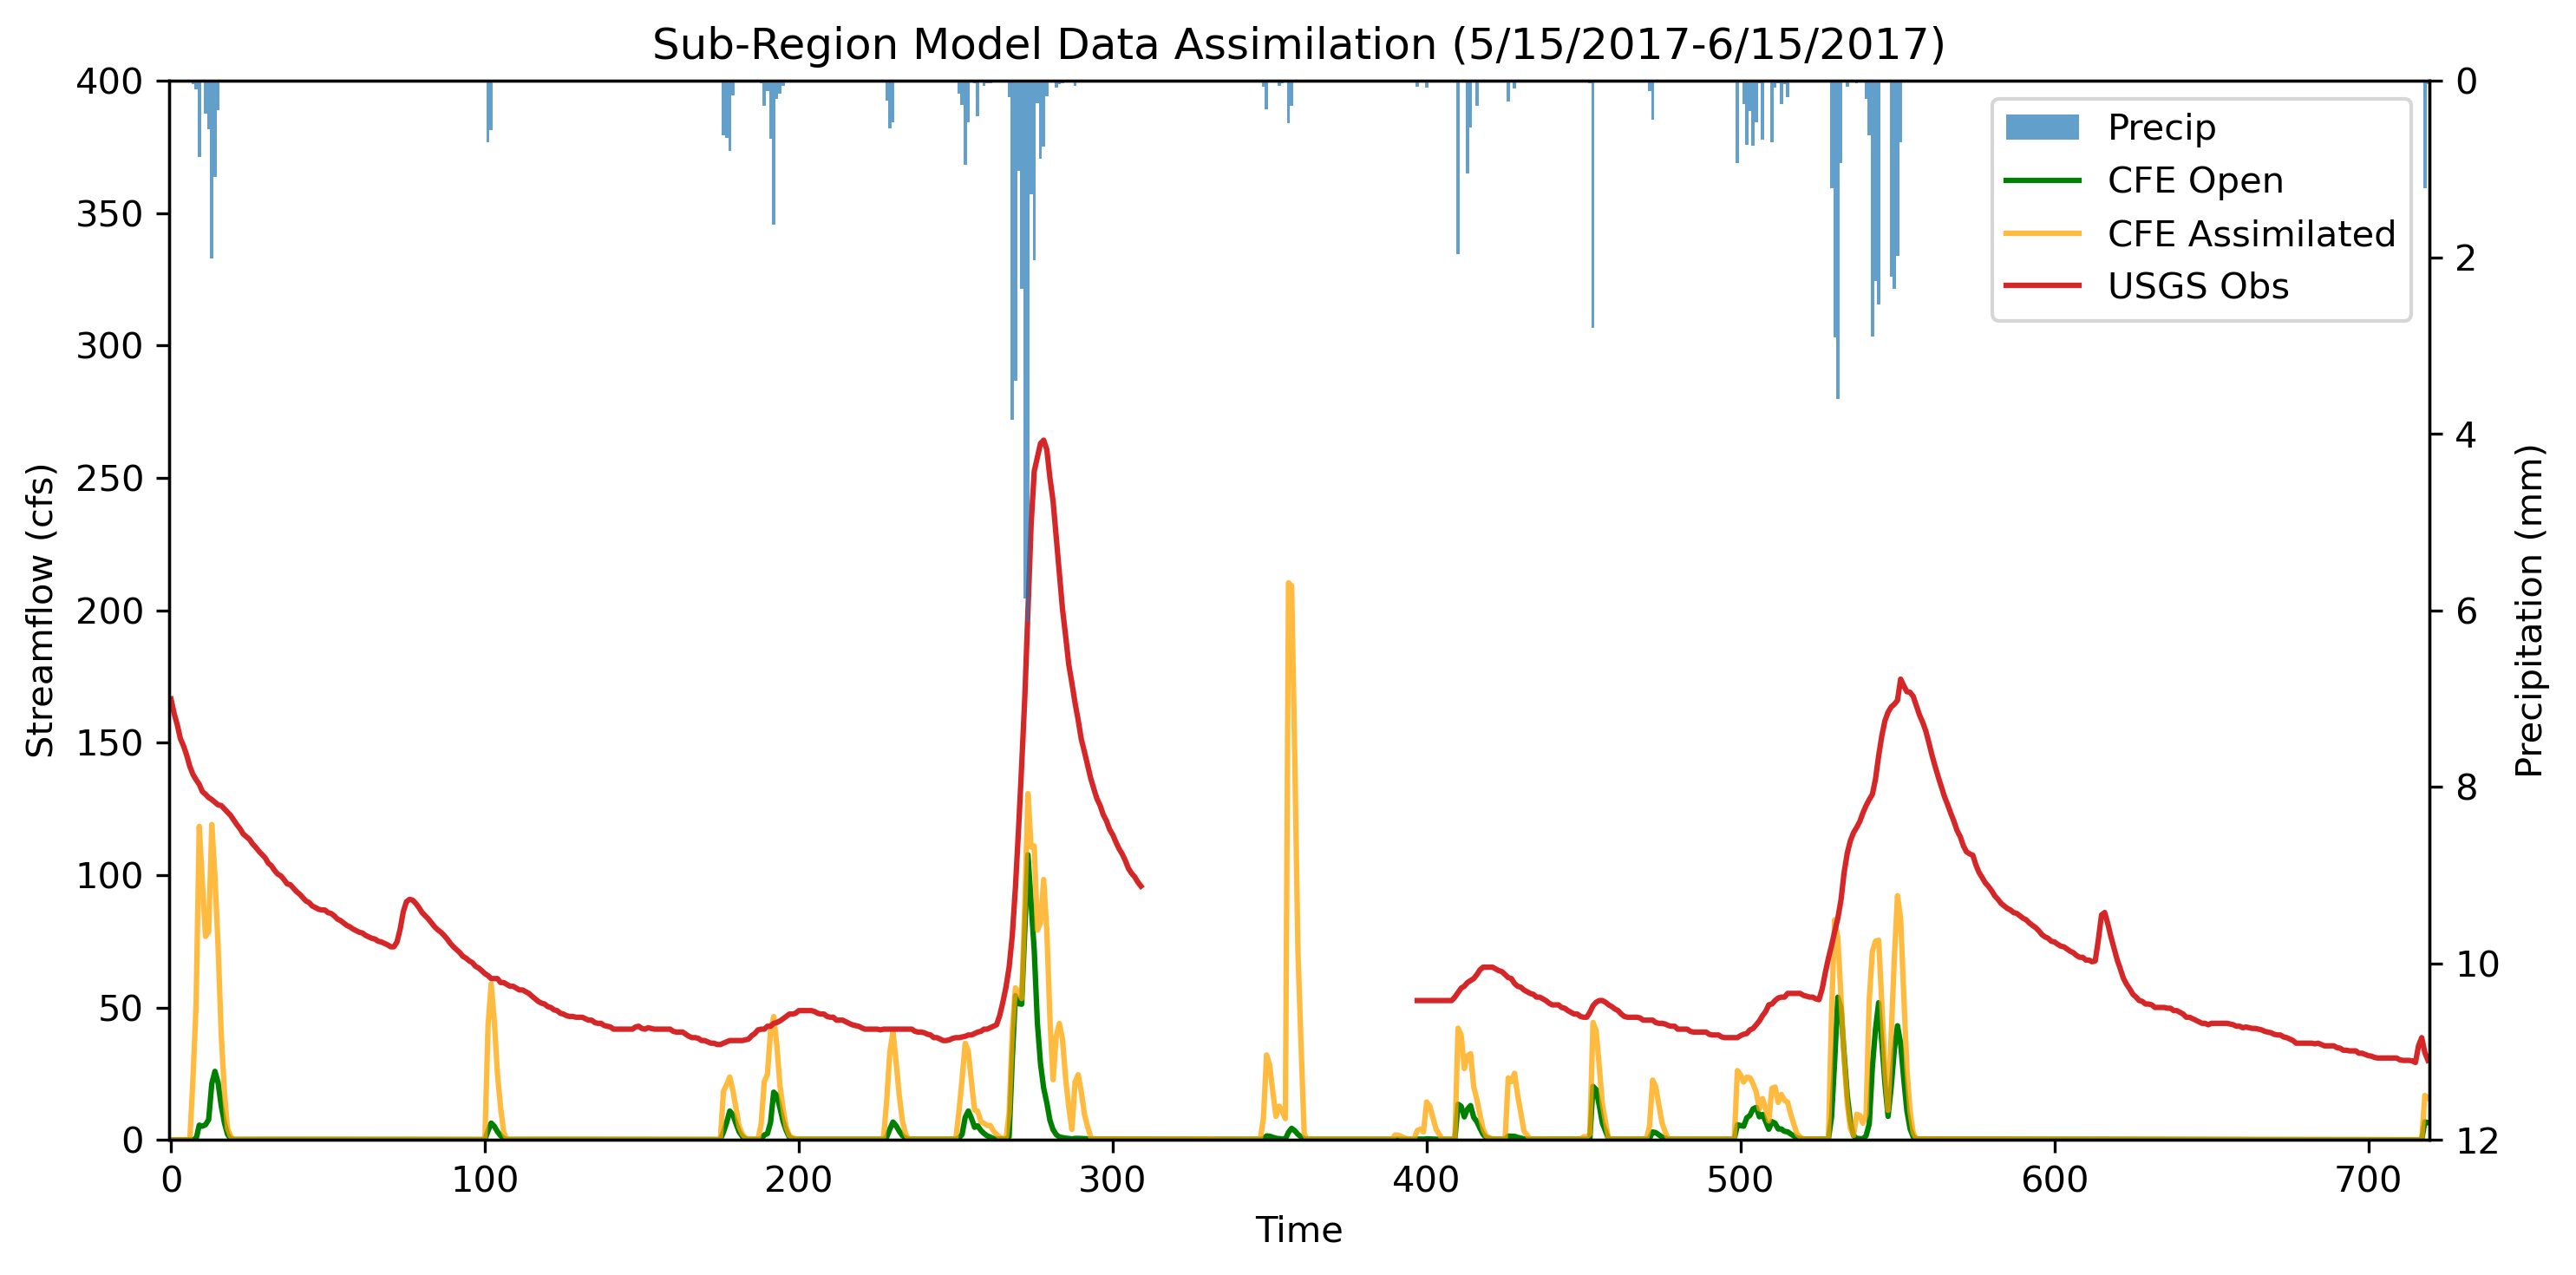

In [7]:
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
ax1.set_ylim(0,400,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')

plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [8]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,166.500,0.018655,0.018655
1,161.000,0.021563,0.021563
2,156.750,0.024276,0.024276
3,151.500,0.026798,0.026798
4,148.750,0.029136,0.029136
...,...,...,...
719,28.400,0.091561,0.091561
720,28.175,0.090991,0.090991
721,28.400,0.090404,0.090404
722,27.500,0.089800,0.089800


In [9]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.41925141584600917
KGE_open= -23.001441754847335
NSE_open= -60.30734886122457
PBias= -2377.2037194320797
r_analysis= 0.45730729747500765
KGE_analysis= -6.988425495764577
NSE_analysis= -10.908082379895555
PBias= -790.582816279243
mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 2.7020572503632385
STD_open= 9.497769973505365
mean_analysis= 7.515916710231552
STD_analysis= 20.13456959669065
